# Setup environment

In [1]:
import pyvista as pv

# Seems that only static plotting is supported on colab at the moment
pv.global_theme.jupyter_backend = 'static'
pv.global_theme.notebook = True
pv.start_xvfb()

# Reproduce code from previous sessions that will be needed again

In [2]:
# Download and upack remeshed FAUST dataset
import os
from tqdm import tqdm
import requests
import shutil

#f not os.path.isdir('FAUST_r'):
#response = requests.get('https://nuage.lix.polytechnique.fr/index.php/s/LJFXrsTG22wYCXx/download?path=%2F&files=FAUST_r.zip', stream=True)
#
#with open("FAUST_r.zip", "wb") as handle:
#    for data in tqdm(response.iter_content()):
#        handle.write(data)
#
#shutil.unpack_archive('FAUST_r.zip', 'FAUST_r')

In [3]:
# manifold harmonics
from robust_laplacian import mesh_laplacian
import numpy as np
from scipy import sparse

def mfd_harmonics(surf: pv.PolyData, n: int):
  # setup generalized eigensystem
  v = np.asarray(surf.points)
  f = np.asarray(surf.faces.reshape(-1, 4)[:, 1:])
  S, M = mesh_laplacian(v, f)
  # solve generalized eigenvalue problem S * v = lambda * M * v
  # (M is diagonal, thus, speed up using change of variables u = M^.5 * v)
  sqrtMinv = sparse.diags(1 / np.sqrt(M.data))
  evals, evecs = sparse.linalg.eigsh(sqrtMinv @ S @ sqrtMinv, n, sigma=-1e-8)
  return evals, sqrtMinv @ evecs, M

# convert functional map to point-to-point map
from sklearn.neighbors import NearestNeighbors

def compute_pt2pt(Phi_S: np.ndarray, Phi_T: np.ndarray, C):
  n_S, n_T = len(Phi_S), len(Phi_T)
  k_T, k_S = C.shape
  nn = NearestNeighbors(n_neighbors=1, n_jobs=-1).fit(Phi_S[:, :k_S] @ C.T)
  idx = nn.kneighbors(Phi_T[:, :k_T], return_distance=False).squeeze()
  return sparse.csr_matrix((np.ones(n_T), (np.arange(n_T), idx)), shape=(n_T, n_S))

In [4]:
# ZoomOut
from typing import NamedTuple, Sequence

class Shape(NamedTuple):
  mesh: pv.PolyData
  Lambda: np.ndarray
  Phi: np.ndarray
  M: sparse.spmatrix

def zoomout(S: Shape, T: Shape, num_step: int = 10, step: Sequence[int] = (1,2)):
  # # init 4x4 functional map assuming aligned shapes ...
  C = np.eye(4)
  C[0,0] = T.Phi[0,0] / S.Phi[0,0]
  # proj = lambda O: O.Phi[:, 1:4].T @ O.M @ (O.mesh.points / O.mesh.points.max(axis=0))
  # # ... using least-square solve
  # # C[1:,1:] = np.linalg.lstsq(proj(S).T, proj(T).T)[0].T
  # # ... solving Procrustes problem
  # U, _, Vt = np.linalg.svd(proj(T) @ proj(S).T)
  # C[1:,1:] = U @ Vt
  #... 'by hand' using knowledge of consistent alignment
  diff = lambda O, i, j: O.mesh.points[O.Phi[:,i].argmax(),j] - O.mesh.points[O.Phi[:,i].argmin(),j]
  C[1,1] = np.sign(diff(S,1,1)) * np.sign(diff(T,1,1))
  C[2,2] = np.sign(diff(S,2,0)) * np.sign(diff(T,2,0))
  C[3,3] = np.sign(diff(S,3,0)) * np.sign(diff(T,3,0))

  # spectral upsampling
  for k_S, k_T in np.outer(np.arange(num_step)+1, step)+C.shape:
    # convert to pt-2-pt map
    P = compute_pt2pt(S.Phi, T.Phi, C)
    # convert to functional map
    C = T.Phi.T[:k_T] @ T.M @ P @ S.Phi[:, :k_S]

  return C

# Pre-compute functional maps for FAUST dataset

In [5]:
path = 'FAUST_preprocessed.npz'

if os.path.isfile(path):
  # load from file system
  data = np.load(path, allow_pickle=True)
  for var in data:
    globals()[var] = data[var]
else:
  idxs = np.mgrid[:10, :10].reshape(2,-1).T
  # read and create surfaces
  shapes = np.empty((10,10), dtype=Shape)
  for id, pose in tqdm(idxs, 'reading surfaces'):
    S = pv.read(f'FAUST_r/off_2/tr_reg_0{id}{pose}.off').extract_surface()
    shapes[id, pose] = Shape(S, *mfd_harmonics(S, 50))

  # estimate functional maps
  d = 50
  fmaps = np.empty(shapes.shape + (d,d))
  S = shapes[0, 0]
  for id, pose in tqdm(idxs, 'computing func. maps'):
    T = shapes[id, pose]
    if S == T:
      fmaps[id, pose] = np.eye(d)
    else:
      fmaps[id, pose] = zoomout(S, T, num_step=d-4, step=(1,1))

  np.savez(path, shapes=shapes, fmaps=fmaps)

In [6]:
shapes.shape, fmaps.shape

((10, 10), (10, 10, 50, 50))

In [7]:
len(fmaps.reshape(-1))

250000

# Compute shape differences

In [8]:
# compute shape differences
# ... area-based
diff = np.einsum('...ji,...jk', fmaps, fmaps)
# ... conformal (w.r.t. Laplace-orthonormal basis)
# L = [[S.Lambda[:d] for S in shape_i] for shape_i in shapes]
# L0_sqrt_inv = 1/np.sqrt(np.clip(shapes[0,0].Lambda, 1e-6, None))
# diff = np.einsum('...ji,...j,...jk', fmaps, L, fmaps) * np.outer(L0_sqrt_inv, L0_sqrt_inv)[None, None]

In [9]:
diff.shape

(10, 10, 50, 50)

# Task 1: Setup of transductive learning approach

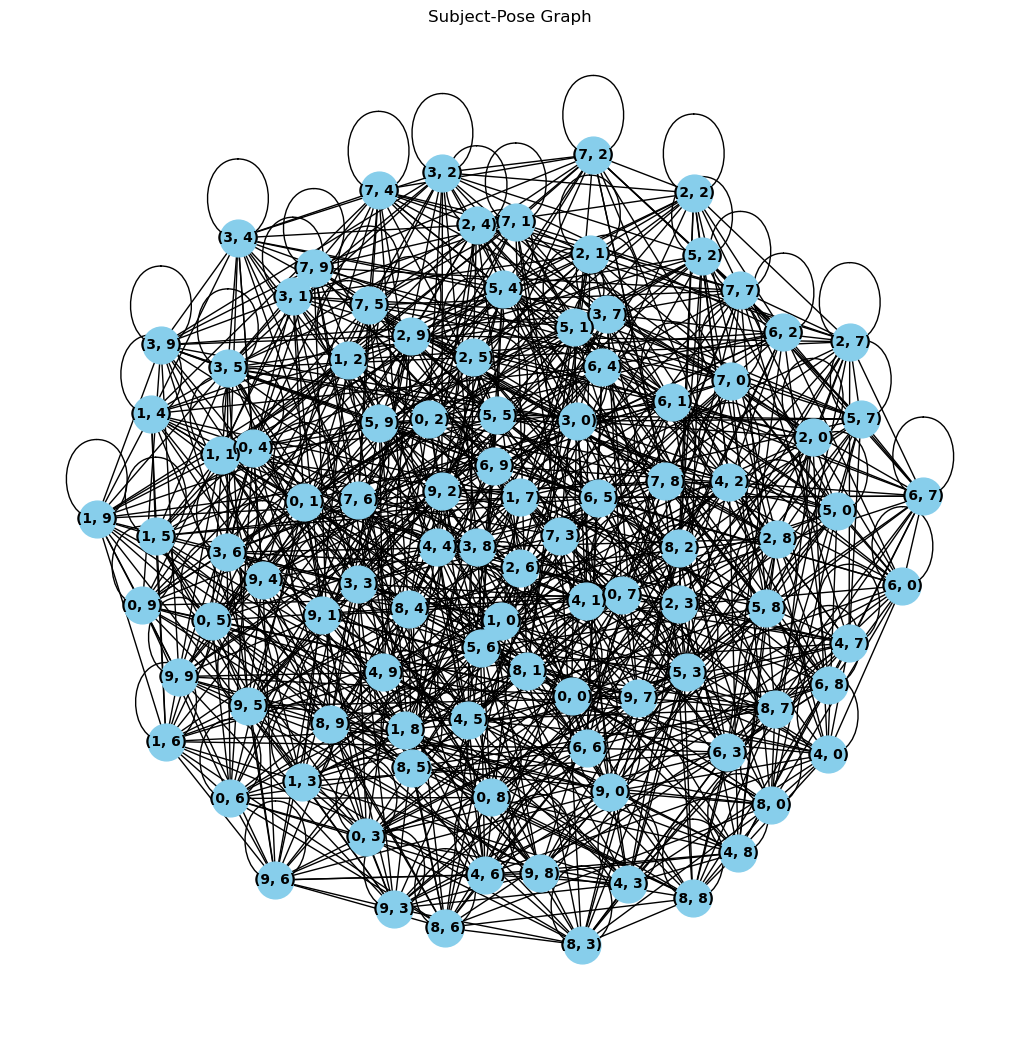

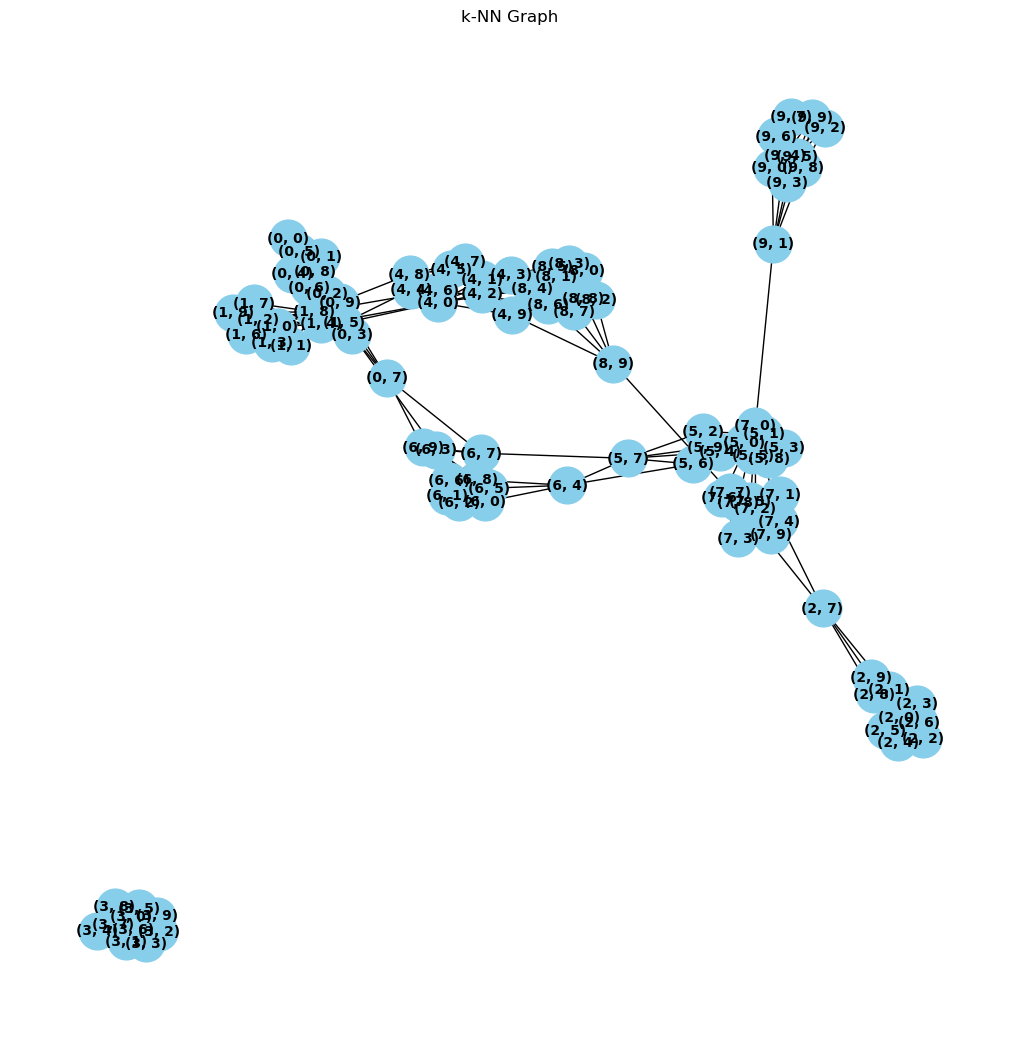

In [10]:
import numpy as np
import networkx as nx
from sklearn.neighbors import NearestNeighbors

# Function to create graph based on same subject or pose
def create_subject_pose_graph(shapes):
    G = nx.Graph()
    idxs = np.mgrid[:10, :10].reshape(2, -1).T
    for i in range(10):
        for j in range(10):
            for k in range(10):
                for l in range(10):
                    if i == k or j == l:  # Same subject or same pose
                        G.add_edge((i, j), (k, l))
    return G

# Function to create k-NN graph based on ShapeDNA
def create_knn_graph(shapes, k=5):
    G = nx.Graph()
    idxs = np.mgrid[:10, :10].reshape(2, -1).T
    L = np.array([shapes[id, pose].Lambda for id, pose in idxs])
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(L)
    distances, indices = nbrs.kneighbors(L)
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors[1:]:  # Skip the first one as it is the point itself
            G.add_edge(tuple(idxs[i]), tuple(idxs[neighbor]))
    return G

# Create the graphs
subject_pose_graph = create_subject_pose_graph(shapes)
knn_graph = create_knn_graph(shapes, k=5)

# Plot graphs for visualization (optional)
import matplotlib.pyplot as plt

def plot_graph(G, title):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title(title)
    plt.show()

plot_graph(subject_pose_graph, "Subject-Pose Graph")
plot_graph(knn_graph, "k-NN Graph")

In [11]:
# Function to compute graph properties
def compute_graph_properties(G):
    num_components = nx.number_connected_components(G)
    clustering_coefficient = nx.average_clustering(G)
    degree_centrality = nx.degree_centrality(G)

    return {
        "num_components": num_components,
        "clustering_coefficient": clustering_coefficient,
        "degree_centrality": degree_centrality
    }

# Compute properties for both graphs
subject_pose_properties = compute_graph_properties(subject_pose_graph)
knn_properties = compute_graph_properties(knn_graph)

# Display properties
print("Subject-Pose Graph Properties:")
print(subject_pose_properties)

print("\nk-NN Graph Properties:")
print(knn_properties)

Subject-Pose Graph Properties:
{'num_components': 1, 'clustering_coefficient': 0.47058823529411653, 'degree_centrality': {(0, 0): 0.20202020202020204, (0, 1): 0.20202020202020204, (0, 2): 0.20202020202020204, (0, 3): 0.20202020202020204, (0, 4): 0.20202020202020204, (0, 5): 0.20202020202020204, (0, 6): 0.20202020202020204, (0, 7): 0.20202020202020204, (0, 8): 0.20202020202020204, (0, 9): 0.20202020202020204, (1, 0): 0.20202020202020204, (2, 0): 0.20202020202020204, (3, 0): 0.20202020202020204, (4, 0): 0.20202020202020204, (5, 0): 0.20202020202020204, (6, 0): 0.20202020202020204, (7, 0): 0.20202020202020204, (8, 0): 0.20202020202020204, (9, 0): 0.20202020202020204, (1, 1): 0.20202020202020204, (2, 1): 0.20202020202020204, (3, 1): 0.20202020202020204, (4, 1): 0.20202020202020204, (5, 1): 0.20202020202020204, (6, 1): 0.20202020202020204, (7, 1): 0.20202020202020204, (8, 1): 0.20202020202020204, (9, 1): 0.20202020202020204, (1, 2): 0.20202020202020204, (2, 2): 0.20202020202020204, (3, 2): 

# Task 2: Graph convolutional network

In [12]:
# G = subject_pose_graph  # Example graph
# # Iterate over nodes
# Node = []
# for node in G:
#     Node.append(node)
# print(Node)
# # Iterate over edges
# for edge in G.edges():
#     None
#     #print("Edge:", edge)
# nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray')
# plt.show()
# len(Node)

In [13]:
# G = nx.Graph()
# idxs = np.mgrid[:10, :10].reshape(2, -1).T
# for i in range(10):
#     for j in range(10):
#         for k in range(10):
#             for l in range(10):
#                 if i == k or j == l:  # Same subject or same pose
#                     G.add_edge((i, j), (k, l))
# print(G.nodes)
# #print("Edges",G.edges)

In [ ]:
import networkx as nx
import jax
import jax.numpy as jnp
import jraph
import haiku as hk
import optax
import matplotlib.pyplot as plt  # Import matplotlib for plotting

from morphomatics.manifold import SPD
from morphomatics.nn import FlowLayer, TangentMLP, MfdInvariant
from morphomatics.nn.train import update, evaluate, TrainingState

def net_fn(G: jraph.GraphsTuple) -> jnp.ndarray:
    n_steps = 1

    # number of channels per node
    n_flow_channel = G.nodes.shape[1]
    #print("n_flow_channel =",n_flow_channel)


    # signal domain
    M = SPD(d=G.nodes.shape[-1], structure='AffineInvariant')
    n_flowLayer = 1

    if G.nodes.shape[1] == 1:
        
      # TangentMLP/MfdInvariant require mulitple channels -> increase by duplicating
        G = G._replace(nodes=jnp.concatenate([G.nodes,]*4, axis=1))
    
    for i in range(n_flowLayer - 1):
        # diffusion layer
        G = FlowLayer(M, max_step_length=1)(G) # max_step_length was set to 1.
        # node-wise MLP
        G = G._replace(nodes=TangentMLP(M, out_sizes=(n_flow_channel,))(G.nodes[None])[0])

    # final diffusion layer
    G = FlowLayer(M, max_step_length=1)(G)
    # node-wise invariant layer
    z = MfdInvariant(M, n_flow_channel)(G.nodes[None])[0]
    z = jax.nn.leaky_relu(z)

    #return hk.nets.MLP([n_flow_channel, n_flow_channel//2, 7], activation=jax.nn.leaky_relu)(z)
    # MLP mapping to class probabilities
    logits = hk.Sequential([
        hk.Linear(n_flow_channel),
        jax.nn.leaky_relu,
        hk.Linear(2)  # Assuming binary classification (female/male)
    ])(z)

    #softmax_probs = jax.nn.softmax(logits, axis=-1)
    return logits

# Example data (you should replace this with actual training process)
# Here we'll use random softmax probabilities for illustration
#softmax_probs = jax.random.uniform(jax.random.PRNGKey(3), shape=(100, 2))
# construct labels
y = (jnp.array([0,1,0,0,1,1,1,0,1,0])[None].T @ jnp.ones(10)[None]).reshape(-1)


P = np.argsort([id*10+pose for (id, pose) in list(subject_pose_graph.adj.keys())])  
#print(P)
A = nx.to_scipy_sparse_array(subject_pose_graph, format='csr')
#print(A)
A = A[P[:,None],P].tocoo()
start_nodes = jnp.asarray(A.row)
#print(start_nodes)
end_nodes = jnp.asarray(A.col)
#print(end_nodes)
n_edges = A.nnz  
#print(n_edges)
d= 50

G = jraph.GraphsTuple(
            n_node=jnp.asarray([100]),
            n_edge=jnp.asarray([n_edges]),
            nodes=jnp.asarray(diff.reshape(-1, 1, 1, d, d)[..., :10, :10], dtype=jnp.float32),
            edges=jnp.ones(n_edges, dtype=jnp.float32),
            globals=None,
            senders=start_nodes,
            receivers=end_nodes)

#print(G)
# choose (stratified) subsets to train/test on
# in-/exclude all poses of a subject (reduces bias due to intra-subject correlation)
mask = (jnp.array([1,1,1,1,1,1,0,0,0,0])[None].T @ jnp.ones(10, dtype=int)[None]).reshape(-1)

# initialize network
net = hk.transform(net_fn)
#print(net)
rng = hk.PRNGSequence(jax.random.key(13))
#print(rng)
params = net.init(next(rng), G)


# initialize optimizer + state
learning_rate = 1e-4
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)
state = TrainingState(params, params, opt_state )

# training
for i in range(100):
  # perform update
  state = update(state, G, y, optimizer, net, next(rng), mask)

  # evaluate accuracy
  train_acc = evaluate(state.avg_params, G, y, 2, net, next(rng), mask)
  test_acc = evaluate(state.avg_params, G, y, 2, net, next(rng), ~mask)

  # print current results
  print({"epoch": f"{i}", "train_acc": f"{train_acc:.3f}", "test_acc": f"{test_acc:.3f}"})


{'epoch': '0', 'train_acc': '0.333', 'test_acc': '0.375'}
{'epoch': '1', 'train_acc': '0.317', 'test_acc': '0.356'}
{'epoch': '2', 'train_acc': '0.350', 'test_acc': '0.381'}
{'epoch': '3', 'train_acc': '0.367', 'test_acc': '0.394'}
{'epoch': '4', 'train_acc': '0.483', 'test_acc': '0.488'}
{'epoch': '5', 'train_acc': '0.450', 'test_acc': '0.463'}
{'epoch': '6', 'train_acc': '0.367', 'test_acc': '0.394'}
{'epoch': '7', 'train_acc': '0.317', 'test_acc': '0.356'}
{'epoch': '8', 'train_acc': '0.300', 'test_acc': '0.344'}
{'epoch': '9', 'train_acc': '0.317', 'test_acc': '0.350'}
{'epoch': '10', 'train_acc': '0.350', 'test_acc': '0.369'}
{'epoch': '11', 'train_acc': '0.317', 'test_acc': '0.350'}
{'epoch': '12', 'train_acc': '0.283', 'test_acc': '0.331'}
{'epoch': '13', 'train_acc': '0.317', 'test_acc': '0.363'}
